# Homework \#1. Linear filters and Convolutions (15 points).

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 9]

## Part 1. Convolutions

### Task \#1
Implement `conv_nested` that is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $I$ and a kernel $k$ as inputs and outputs the convolved image $f*h$ that has the same shape as the input image. Assume that pixels that outside of source images borders have intensity 0. Test your `conv_nested` function on a real image using gaussian kernel (3x3).

In [3]:
def conv_nested(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    gap_x, gap_y = np.array(kernel.shape) // 2
    padded = np.zeros(np.array(image.shape) + np.array(kernel.shape))
    padded[gap_x:~gap_x, gap_y:~gap_y] = image
    output = np.zeros_like(image)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            for i in range(kernel.shape[0]):
                for j in range(kernel.shape[1]):
                    output[x, y] += kernel[i, j] * padded[x + gap_x - i, y + gap_y - j]
            
    return output

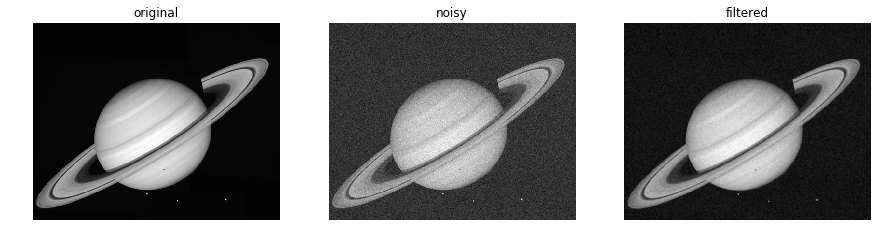

In [4]:
img = cv2.imread('./images/saturn.png', cv2.IMREAD_GRAYSCALE)
img_noisy = img + 10*np.random.randn(*img.shape)
kernel = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray');
plt.title('original'), plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(img_noisy, cmap='gray');
plt.title('noisy'), plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(conv_nested(img_noisy, kernel), cmap='gray');
plt.title('filtered'), plt.axis("off");

## Part 2. Cross-correlation

### Task \#2
We saw that we can use cross-correlation to look for templates in images. Implement finding favorite on the shelf using cross-correlation.

Shelf:
![shelf.png](./images/shelf.png)

Favorite:
![shelf.png](./images/favorite.jpg)

In [5]:
from scipy.signal import correlate2d

def find_template_2D(t, s):
    c = correlate2d(s, t, mode='same')
    x, y = np.unravel_index(np.argmax(c), c.shape)
    return x - t.shape[0] // 2, y - t.shape[1] // 2

Upper left point: (-28, 225)


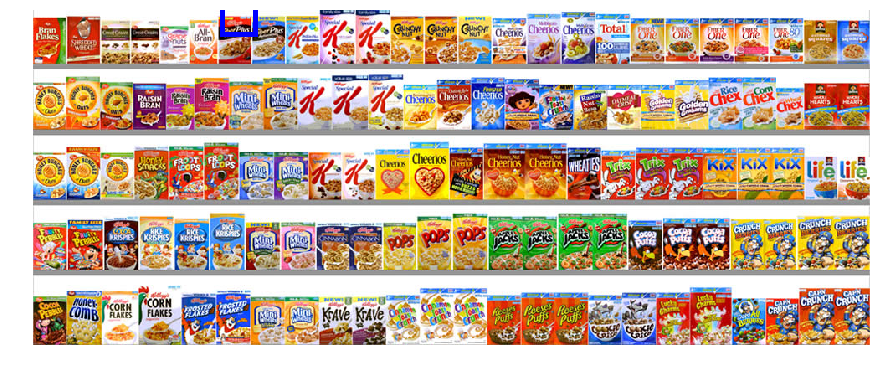

In [6]:
import matplotlib.patches as patches

shelf = cv2.imread('./images/shelf.png')
favorite = cv2.imread('./images/favorite.jpg', cv2.IMREAD_GRAYSCALE)

x, y = find_template_2D(favorite, cv2.cvtColor(shelf, cv2.COLOR_BGR2GRAY))
print(f'Upper left point: {x, y}')

fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(shelf, cv2.COLOR_BGR2RGB));

rect = patches.Rectangle((y, x), favorite.shape[1], favorite.shape[0], linewidth=5, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.show();

### Task \#3 (optional)
In previous task try implementing zero-mean cross-correlation (subtract the mean value of the template so that it has zero mean). 

In [7]:
from scipy.signal import correlate2d

def find_template_2D(t, s):
    t = t - t.mean()
    s = s - s.mean()
    c = correlate2d(s, t, mode='same')
    x, y = np.unravel_index(np.argmax(c), c.shape)
    return x - t.shape[0] // 2, y - t.shape[1] // 2

Upper left point: (7, 41)


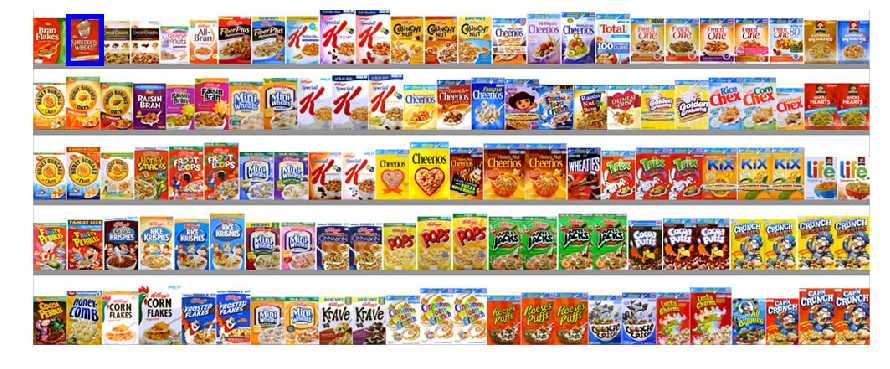

In [8]:
import matplotlib.patches as patches

shelf = cv2.imread('./images/shelf.png')
favorite = cv2.imread('./images/favorite.jpg', cv2.IMREAD_GRAYSCALE)

x, y = find_template_2D(favorite, cv2.cvtColor(shelf, cv2.COLOR_BGR2GRAY))
print(f'Upper left point: {x, y}')

fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(shelf, cv2.COLOR_BGR2RGB));

rect = patches.Rectangle((y, x), favorite.shape[1], favorite.shape[0], linewidth=5, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.show();

### Task \#4 (optional)
Modify algorithm for cases of changing light conditions using normalized cross-correlation (normalize the pixels of the image and template at every step before comparing them). Test on dark shelf.

Dark shelf:

![dark_shelf.png](./images/dark_shelf.jpg)

In [9]:
from scipy.signal import correlate2d

def find_template_2D(t, s):
    t = (t - t.mean()) / t.std()
    s = (s - s.mean()) / s.std()
    c = correlate2d(s, t, mode='same')
    x, y = np.unravel_index(np.argmax(c), c.shape)
    return x - t.shape[0] // 2, y - t.shape[1] // 2

Upper left point: (102, 630)


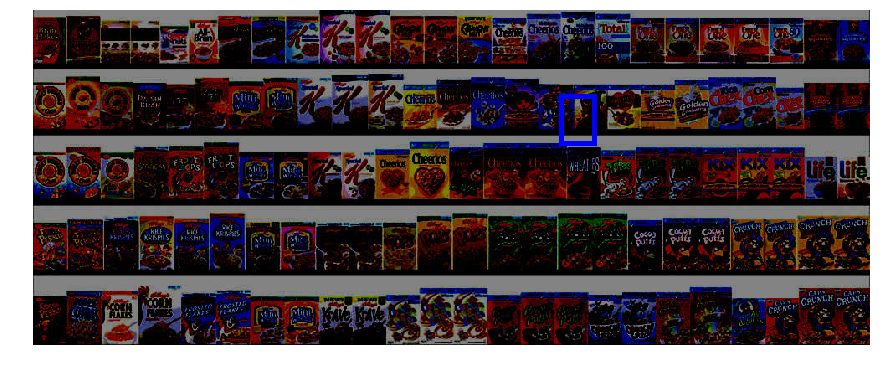

In [10]:
import matplotlib.patches as patches

shelf = cv2.imread('./images/dark_shelf.jpg')
favorite = cv2.imread('./images/favorite.jpg', cv2.IMREAD_GRAYSCALE)

x, y = find_template_2D(favorite, cv2.cvtColor(shelf, cv2.COLOR_BGR2GRAY))
print(f'Upper left point: {x, y}')

fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(shelf, cv2.COLOR_BGR2RGB));

rect = patches.Rectangle((y, x), favorite.shape[1], favorite.shape[0], linewidth=5, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.show();

## Part 3. Hybrid images.

### Task \#5
We want to construct the image convolution function (i.e. image filtering) and use it to create hybrid image. The technique was invented by Oliva, Torralba, and Schyns in 2006, and published in a paper at SIGGRAPH. High frequency image content tends to dominate perception but, at a distance, only low frequency (smooth) content is perceived. By blending high and low frequency content, we will be able to create a hybrid image that is perceived differently at different distances.
A hybrid image is the sum of a low-pass filtered version of a first image and a high-pass filtered version of a second image. Use free parameter (cut-off frequency) for each image pair to controls how much high frequency to remove from the first image and how much low frequency to leave in the second image.

In [11]:
def low_pass_filter(image, shape=(10, 10)):
    return cv2.blur(image, shape)

def high_pass_filter(image, shape=(10, 10)):
    return image - low_pass_filter(image, shape) + 128

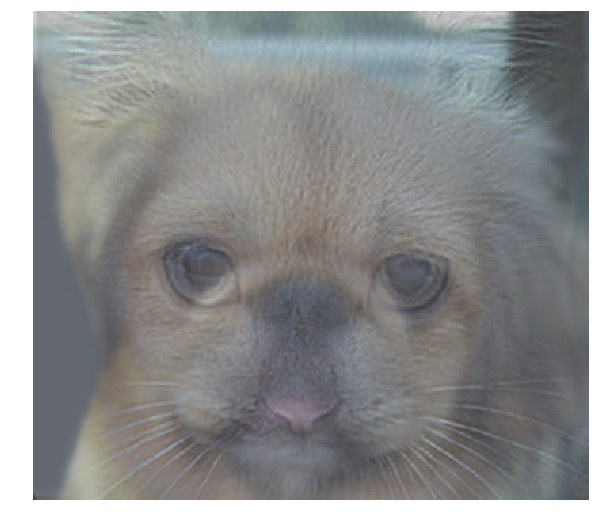

In [12]:
def hybrid(image1, image2):
    return low_pass_filter(image1) // 2 + high_pass_filter(image2) // 2

cat = cv2.cvtColor(cv2.imread('./images/cat.jpg'), cv2.COLOR_BGR2RGB)
dog = cv2.cvtColor(cv2.imread('./images/dog.jpg'), cv2.COLOR_BGR2RGB)

plt.imshow(hybrid(dog, cat));
plt.axis('off');